# Logistic Regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

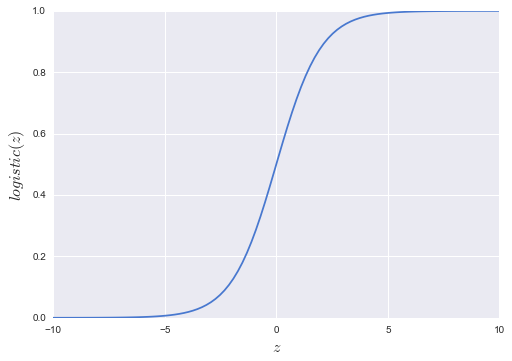

In [2]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)
plt.savefig('B04958_05_01.png', dpi=300, figsize=(5.5, 5.5))

In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


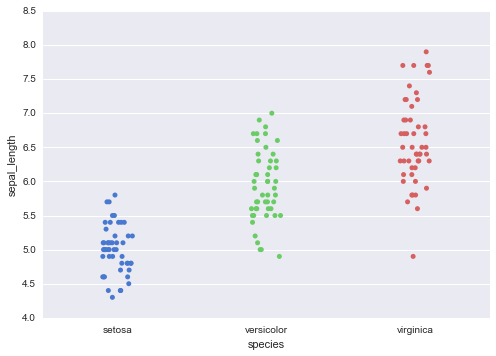

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B04958_05_03.png', dpi=300, figsize=(5.5, 5.5))

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


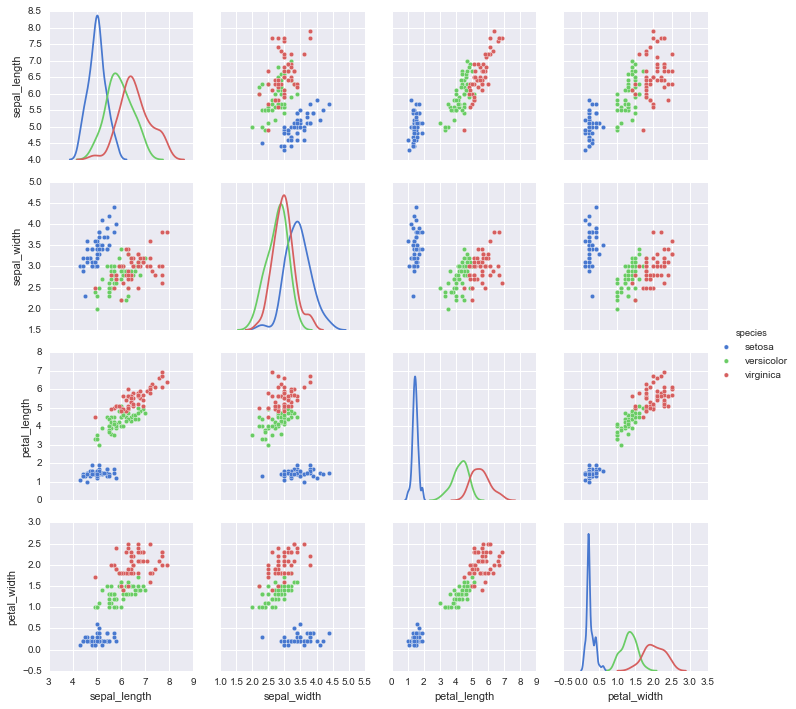

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B04958_05_04.png', dpi=300, figsize=(5.5, 5.5))

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [7]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 5000/5000 [00:15<00:00, 316.81it/s]


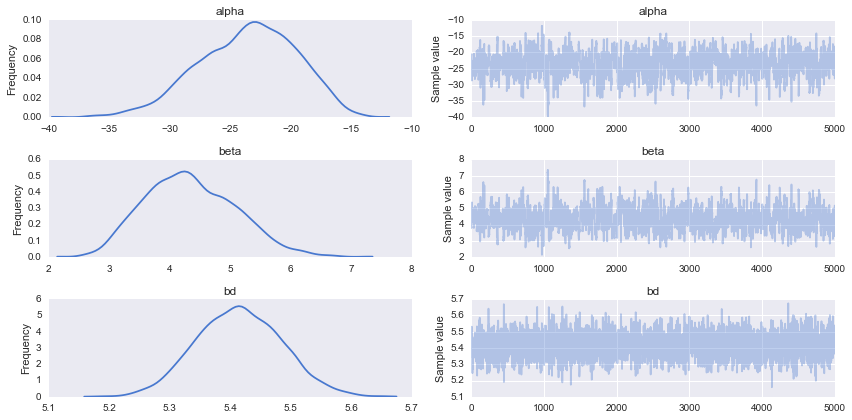

In [8]:
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames)
plt.savefig('B04958_05_05.png', dpi=300, figsize=(5.5, 5.5))

In [9]:
#pm.autocorrplot(trace_0, varnames);

In [10]:
#sns.kdeplot(trace_0['alpha'], cadena_0['beta']);

In [11]:
pm.df_summary(trace_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-23.55,4.08,1.75e-01,-31.03,-15.90
beta,4.35,0.76,3.24e-02,2.96,5.77
bd,5.42,0.07,1.10e-03,5.29,5.56


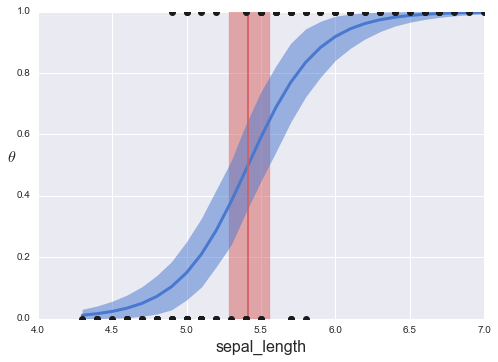

In [12]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))

In [13]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([ 0.14,  0.59,  0.93]), array([False,  True,  True], dtype=bool))

## Multiple logistic regression

In [14]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [15]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    #start = pm.find_MAP()
    #step = pm.NUTS()
    #trace_1 = pm.sample(5000, step, start)
    trace_1 = pm.sample(5000)

100%|██████████| 5000/5000 [00:21<00:00, 233.12it/s]


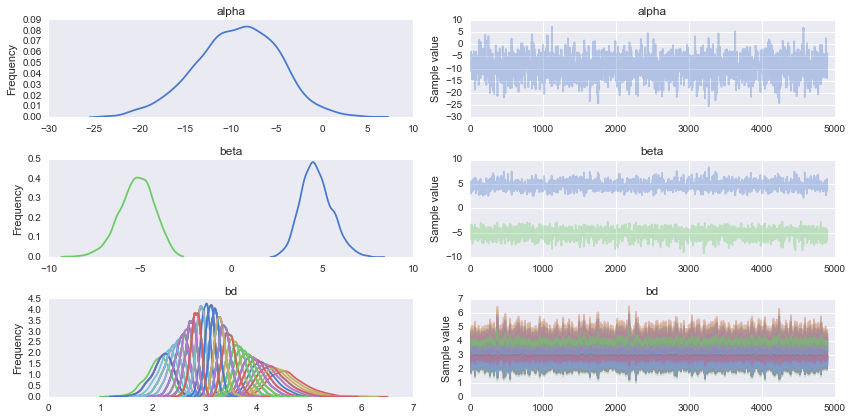

In [16]:
chain_1 = trace_1[100:]
pm.traceplot(chain_1)
plt.savefig('B04958_05_07.png', dpi=300, figsize=(5.5, 5.5))

In [17]:
#pm.df_summary(chain_1, ['alpha', 'beta'])

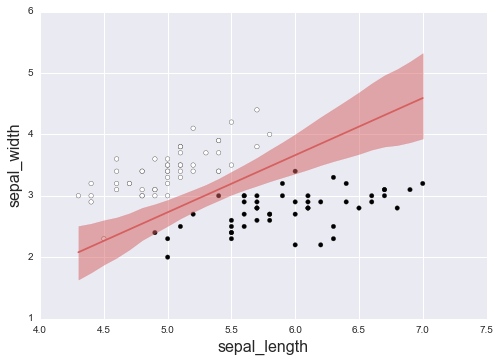

In [18]:
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0)
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_08.png', dpi=300, figsize=(5.5, 5.5))

## Correlated variables

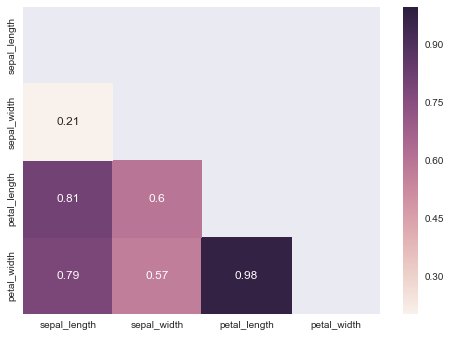

In [19]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True)
plt.savefig('B04958_05_09.png', dpi=300, figsize=(5.5, 5.5))

## Unbalanced Classes

In [20]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [21]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

100%|██████████| 5000/5000 [00:19<00:00, 253.83it/s]


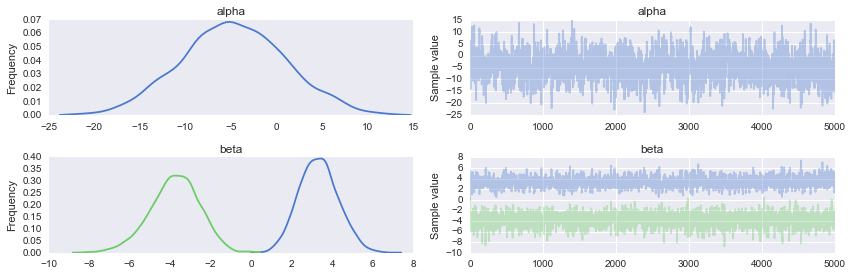

In [22]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [23]:
pm.df_summary(cadena_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.70,5.79,0.19,-15.39,7.18
beta__0,3.33,0.97,0.03,1.49,5.26
beta__1,-3.77,1.24,0.03,-6.30,-1.48


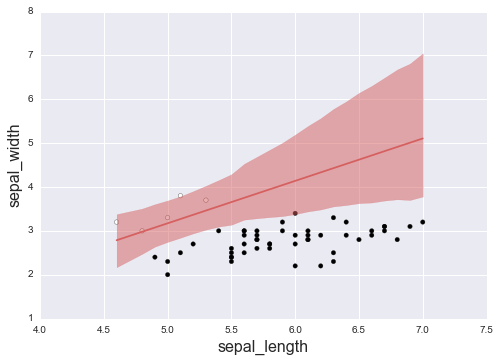

In [24]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_10.png', dpi=300, figsize=(5.5, 5.5))

## Softmax logistic regression (AKA multinomial regression)

In [25]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [26]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(2000, step, start)

100%|██████████| 2000/2000 [00:24<00:00, 82.84it/s]


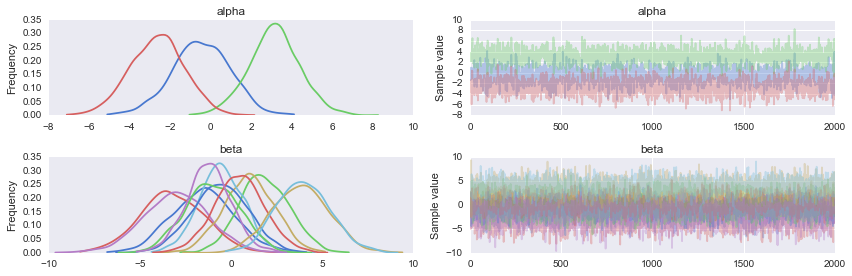

In [27]:
pm.traceplot(trace_s)
plt.savefig('B04958_05_12.png', dpi=300, figsize=(5.5, 5.5))

In [28]:
pm.df_summary(trace_s)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,-0.47,1.43,0.04,-3.33,2.15
alpha__1,3.15,1.26,0.03,0.53,5.53
alpha__2,-2.64,1.34,0.03,-5.24,-0.05
beta__0_0,-1.51,1.71,0.04,-4.72,2.00
beta__0_1,0.99,1.39,0.04,-1.80,3.55
beta__0_2,0.46,1.39,0.04,-2.16,3.25
beta__1_0,1.84,1.36,0.04,-0.68,4.60
beta__1_1,-0.53,1.24,0.03,-2.87,1.91
beta__1_2,-1.22,1.24,0.03,-3.50,1.35
beta__2_0,-3.22,1.76,0.04,-6.71,0.20


In [29]:
#pm.autocorrplot(trace_s, varnames=['alpha']);

In [30]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.97333333333333338

In [31]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_sf = pm.sample(2000, step, start)

100%|██████████| 2000/2000 [00:27<00:00, 73.07it/s]


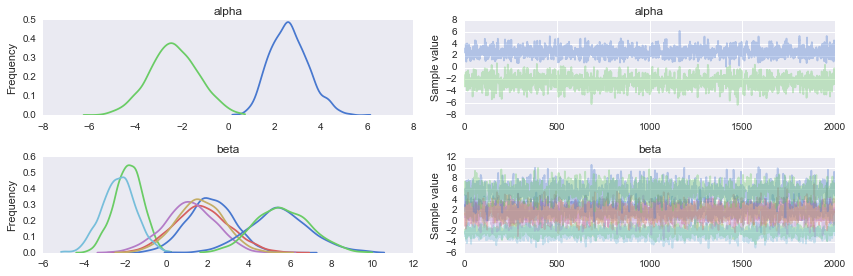

In [32]:
pm.traceplot(trace_sf)
plt.savefig('B04958_05_13.png', dpi=300, figsize=(5.5, 5.5))

In [33]:
pm.df_summary(trace_sf)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.64,0.83,0.02,1.17,4.33
alpha__1,-2.36,1.06,0.03,-4.43,-0.27
beta__0_0,2.12,1.14,0.04,-0.12,4.32
beta__0_1,1.61,1.17,0.04,-0.61,3.97
beta__1_0,-1.86,0.69,0.02,-3.23,-0.57
beta__1_1,-2.32,0.83,0.02,-4.00,-0.76
beta__2_0,1.72,1.36,0.04,-0.72,4.51
beta__2_1,5.48,1.52,0.05,2.33,8.36
beta__3_0,1.12,1.26,0.04,-1.21,3.71
beta__3_1,5.64,1.35,0.05,3.13,8.38


## Linear discriminat Analysis

In [34]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [35]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_lda = pm.sample(5000, step, start)

100%|██████████| 5000/5000 [00:08<00:00, 605.56it/s]


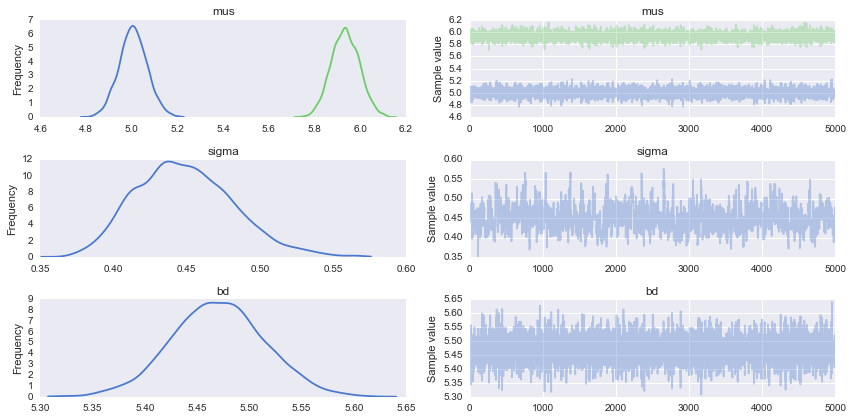

In [36]:
pm.traceplot(trace_lda)
plt.savefig('B04958_05_14.png', dpi=300, figsize=(5.5, 5.5))

In [37]:
pm.df_summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mus__0,5.01,0.06,8.16e-04,4.88,5.13
mus__1,5.93,0.06,6.28e-04,5.81,6.06
sigma,0.45,0.03,1.52e-03,0.38,0.51
bd,5.47,0.05,5.36e-04,5.38,5.56


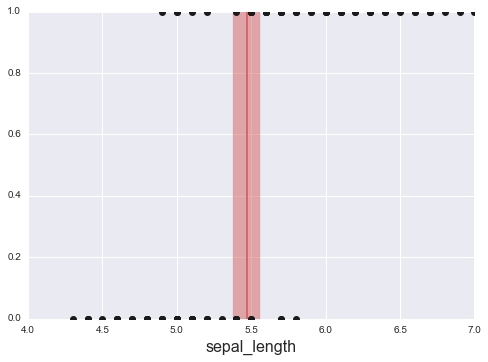

In [38]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)
plt.savefig('B04958_05_15.png', dpi=300, figsize=(5.5, 5.5))

In [39]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc2
NumPy 1.11.1
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1
Pandas 0.19.0
